In [1]:
import numpy as np
from qibo import gates, hamiltonians, models
from scipy.optimize import minimize
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import argparse

[Qibo|WARNING|2021-03-28 10:24:17]: Custom operators not found, skipping custom operators load.
[Qibo|WARNING|2021-03-28 10:24:17]: Removing custom operators from available backends.
[Qibo|WARNING|2021-03-28 10:24:17]: Einsum will be used to apply gates with tensorflow.


In [2]:
def hamiltonian(nqubits):
        m0 = (1/nqubits)*hamiltonians.Z(nqubits, numpy=True).matrix
        ham = hamiltonians.Hamiltonian(nqubits, m0)
        return ham
    
def generator(params, x):
    circuit = models.Circuit(nqubits)
    circuit.add(gates.RY(0, params[0]*x + params[1]))
    circuit.add(gates.RY(1, params[2]*x + params[3]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[4]*x + params[5]))
    circuit.add(gates.RY(1, params[6]*x + params[7]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[8]*x + params[9]))
    circuit.add(gates.RY(1, params[10]*x + params[11]))
    return circuit
    
def cost_generator(params, opt_params_disc, count):
    #run discriminator
    fake_state = discriminator(opt_params_disc).execute(np.copy(generator(params).execute()))
    prob_fake_true = (encoder.expectation(fake_state).numpy().real + 1)/2
    cost = -prob_fake_true
                
    if count[0] % 10 == 0:
        print('Prob fake as real: ', (encoder.expectation(fake_state).numpy().real + 1)/2)
        print(count[0], cost)
    count[0] += 1      
        
    return cost

def discriminator(params, x):
    circuit = models.Circuit(nqubits)
    circuit.add(gates.RY(0, params[0]))
    return circuit
        
def cost_discriminator(params, opt_params_gen, count):
    cost = 0
    #run real data
    real_state = discriminator(params).execute(np.copy(initial_state([0.5]).execute()))
    prob_real_true = (1 - encoder.expectation(real_state).numpy().real)/2
    #run fake data
    fake_state = discriminator(params).execute(np.copy(generator(opt_params_gen).execute()))
    prob_fake_true = (1 - encoder.expectation(fake_state).numpy().real)/2

    cost = prob_fake_true - prob_real_true
        
    if count[0] % 10 == 0:
        print(count[0], cost)
        print('Prob real as real: ', (encoder.expectation(real_state).numpy().real + 1)/2)
        print('Prob fake as real: ', (encoder.expectation(fake_state).numpy().real + 1)/2)
    count[0] += 1
        
    return cost

def sample_gaussian(mu, sigma, samples, bins):
    s = np.random.normal(mu, sigma, samples)
    count, bins, ignored = plt.hist(s, bins)
    return count, bins


In [3]:
nqubits = 2
encoder = hamiltonian(nqubits)
nparams_gen = 12
nparams_disc = 1
initial_params_disc = np.random.uniform(0, 2*np.pi, nparams_disc)
initial_params_gen = np.random.uniform(0, 2*np.pi, nparams_gen)

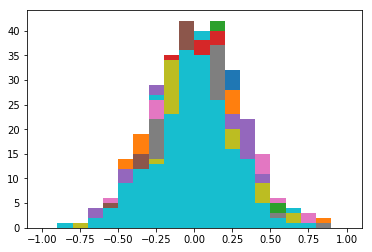

In [4]:
real_gaussian = []
bins = np.linspace(-1.0, 1.0, 21)
for i in range(50):
    count, bins = sample_gaussian(0, 0.25, 200, bins)
    real_gaussian.append(count)

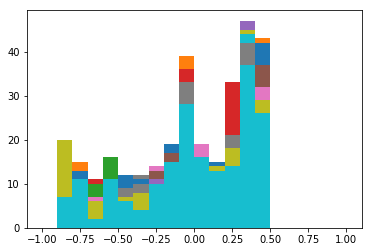

In [5]:
fake_gaussian = []
for j in range(50):
    fake_gaussian_sampling = []
    for i in range(200):
        x = np.random.uniform(-1, 1)
        fake_sample = encoder.expectation(generator(initial_params_gen, x).execute()).numpy().real
        fake_gaussian_sampling.append(fake_sample)
    count, bins, ignored = plt.hist(fake_gaussian_sampling, bins)
    fake_gaussian.append(count)

In [6]:
"""
count = [0]
print('\n Discriminator results: ')
result_disc = minimize(lambda p: cost_discriminator(p, initial_params_gen, count), initial_params,
                          method='BFGS', options={'maxiter': 1.0e3})
print('Final parameters: ', result_disc.x)
print('Final cost function: ', result_disc.fun)
    
print('\n Generator results: ')
result_gen = minimize(lambda p: cost_generator(p, result_disc.x, count), initial_params_gen,
                          method='BFGS', options={'maxiter': 1.0e3})
print('Final parameters: ', result_gen.x)
print('Final cost function: ', result_gen.fun)

for i in range(15):

    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count), result_disc.x,
                          method='BFGS', options={'maxiter': 1.0e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)

    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, count), result_gen.x,
                          method='BFGS', options={'maxiter': 1.0e3})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
"""

"\ncount = [0]\nprint('\n Discriminator results: ')\nresult_disc = minimize(lambda p: cost_discriminator(p, initial_params_gen, count), initial_params,\n                          method='BFGS', options={'maxiter': 1.0e3})\nprint('Final parameters: ', result_disc.x)\nprint('Final cost function: ', result_disc.fun)\n    \nprint('\n Generator results: ')\nresult_gen = minimize(lambda p: cost_generator(p, result_disc.x, count), initial_params_gen,\n                          method='BFGS', options={'maxiter': 1.0e3})\nprint('Final parameters: ', result_gen.x)\nprint('Final cost function: ', result_gen.fun)\n\nfor i in range(15):\n\n    print('\n Discriminator results: ')\n    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count), result_disc.x,\n                          method='BFGS', options={'maxiter': 1.0e3})\n    print('Final parameters: ', result_disc.x)\n    print('Final cost function: ', result_disc.fun)\n\n    print('\n Generator results: ')\n    result_gen = 